Notebook for the CNN 2D with flatten dataset feature wise and images scaled image wise

In [ ]:
from google.colab import drive
drive.mount('./gdrive')

Mounted at ./gdrive


In [ ]:
DRIVE = "../gdrive/MyDrive/ann_dataset/HW2"

In [ ]:
import pickle
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import pandas as pd

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast, Rescaling, AveragePooling2D
import numpy as np

# Load data

The data is ingested as labeled 36x36 images

In [ ]:
# load data split
with open("./gdrive/MyDrive/ann_dataset/HW2/dataUsed/train_test_objKeep9", "rb") as f:
  x_train, x_test, y_train, y_test = pickle.load(f)

In [ ]:
# load scaler
with open("./gdrive/MyDrive/ann_dataset/modelss/scaler.p", "rb") as f:
  scaler = pickle.load(f)

In [ ]:
# lead data
# Separate the test data
with open(f"{DRIVE}/dataUsed/test_obj_flatten_images_255value", "rb") as f:
    x, x_test, y, y_test = pickle.load(f)
with open(f"{DRIVE}/dataUsed/trainANDval_obj_flatten_images_255value", "rb") as f:
    x_train, y_train = pickle.load(f)

In [ ]:
def augment_data(x_train, y_train, oversample=True):
    """ Oversample the images up to the majority class """
    lengths = []
    for label in np.unique(y_train):
        lengths.append(np.sum(y_train == label))
    id_max = np.argmax(lengths)
    max_len = lengths[id_max]

    x_train_aug = []
    y_train_aug = []
    for label in np.unique(y_train):
        samples = x_train[y_train == label]
        labels = y_train[y_train == label]
        indexes = list(np.random.randint(len(samples), size=max_len-len(samples)))
        extra_samples = samples[indexes]
        extra_labels = labels[indexes]
        x_train_aug += list(samples) + list(extra_samples)
        y_train_aug += list(labels) + list(extra_labels)

    idx_shuffle = list(range(len(y_train_aug)))
    np.random.shuffle(idx_shuffle)
    return np.array(x_train_aug)[idx_shuffle], np.array(y_train_aug)[idx_shuffle]

In [ ]:
# reproduce the same image for all 3 channels of the cnn

x_train = np.repeat(x_train[..., np.newaxis], 3, -1)
x_test = np.repeat(x_test[..., np.newaxis], 3, -1)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [ ]:
BATCH_SIZE = 64
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

 # Plot images

In [ ]:
def from_raw_to_dataframe(x_raw, y_raw):
    tabular_list = []
    for i_sample, x in enumerate(x_raw):
        for i_time, xx in enumerate(x):
            tabular_list.append([i_sample, i_time] + list(xx) + [y_raw[i_sample]])
    df_res = pd.DataFrame(tabular_list).rename(columns={
        0: 'sample_id',
        1: 'time',
        2: 'feat_1',
        3: 'feat_2',
        4: 'feat_3',
        5: 'feat_4',
        6: 'feat_5',
        7: 'feat_6',
        8: 'label'}, inplace=False, errors='raise')
    return df_res

In [ ]:
def build_sequences(df):
    # Sanity check to avoid runtime errors
    #assert window % stride == 0
    dataset = []
    labels = []
    for id in df['sample_id'].unique():
        # Take only meaningful features
        temp = df[df['sample_id'] == id][['feat_1','feat_2','feat_3','feat_4','feat_5','feat_6']].values
        # Save the label
        label = df[df['sample_id'] == id]['label'].values[0]
        labels.append(label)
        dataset.append(temp)

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler


def normalize_data_feature_wise(x_original, y_original, max_value=1, quantile=False):
    x_original_tabular = from_raw_to_dataframe(x_original, y_original)
    if quantile:
        scaler = RobustScaler()
    else:
        scaler = MinMaxScaler(feature_range=(0, max_value))
    scaler.fit_transform(x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']])
    x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']] = scaler.transform(
        x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']])

    agg_x, agg_y = build_sequences(x_original_tabular)
    return agg_x, agg_y, scaler

In [ ]:
def apply_scaler_to_new_data(x,y,scaler):
  x_original_tabular = from_raw_to_dataframe(x, y)
  x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']] = scaler.transform(x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']])
  agg_x, agg_y = build_sequences(x_original_tabular)
  return agg_x, agg_y

In [ ]:
def shiftLeft(lst) :
    return lst[1:] + lst[:1]

def shiftRight(lst) :
    return lst[-1:] + lst[:-1]

def array_1D_to_2D(array, option=2):
  """ mappind 1D arrays to 2D images like arrays with the specified option"""
  base = list(array.copy())
  twoD_array = []

  if option == 0:
  # every row do a right shift
      for i in range(len(base)):
          twoD_array.append(base)
          base = shiftLeft(base)
  elif option == 1:
  # for iteration i do i right shifts of previous row
      for i in range(len(base)):
          twoD_array.append(base)
          for _ in range(i):
              base = shiftLeft(base)
  elif option == 2:
  # shift the same number of filter size (3)
      for i in range(len(base)):
          twoD_array.append(base)
          for _ in range(3):
              base = shiftLeft(base)
  elif option == 3:
  # shift the same number of filter size (3)
    for i in range(len(base)):
        # for i in range(len(base)):
        twoD_array.append(base)
          # base = shiftLeft(base)
  return twoD_array

In [ ]:
def original_data_to_image_data(x_original, y_original, option):
    x_original_image = []
    y_original_image = []


    for i, label in enumerate(y_original):
        images_block = []
        for feat_id in range(x_original[i].shape[1]):
            ts = np.array(x_original[i][:, feat_id])
            image = array_1D_to_2D(ts, option)
            images_block.append(image)

        x_original_image.append(np.array(images_block))
        y_original_image.append(np.array(label))
        # x_original_image[0][0, :]
        # x_original_image_r[0][:,:, 0]
    # x_original_image_r = np.reshape(x_original_image, (len(x_original), 36, 36, 6))
    return x_original_image, y_original_image

In [ ]:
def normalize_image_by_image(x_original, y_original):
    x_tmp = x_original.copy()
    for i,_ in enumerate(x_original):
        for j in range(6):
            minn = np.min(x_original[i][:, j])
            maxx = np.max(x_original[i][:, j])
            for x in range(36):
                x_tmp[i, x, j] = (x_original[i, x, j] - minn) / (maxx - minn)
    return x_tmp, y_original

In [ ]:
x_train_norm, y_train_norm = apply_scaler_to_new_data(x_train, y_train, scaler)
x_test_norm, y_test_norm = apply_scaler_to_new_data(x_test, y_test, scaler)

In [ ]:
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train_norm)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test_norm)).batch(BATCH_SIZE)

In [ ]:
import matplotlib.pyplot as plt


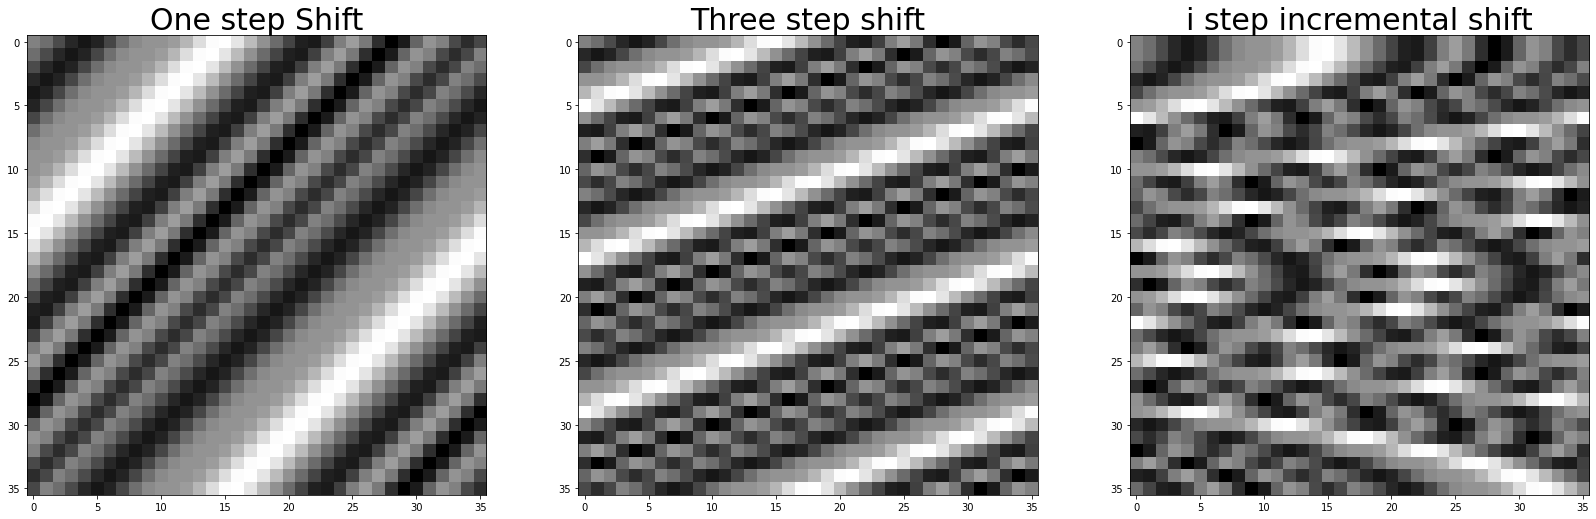

In [ ]:
target = 1

"""x_img,y_img = normalize_image_by_image(x_train, y_train)
x_img,y_img = original_data_to_image_data(x_img, y_img, option)
img_test = x_img[target]"""

img, axs = plt.subplots(1,3, figsize=(28,26))
options = [0,2,1]
titles = ['One step Shift', 'Three step shift', 'i step incremental shift']

for i in range(3):
  x_img,y_img = normalize_image_by_image(x_train, y_train)
  x_img,y_img = original_data_to_image_data(x_img, y_img, option=options[i])
  img_test = x_img[target]
  axs[i].imshow(255*img_test[0], cmap='gray', vmin=0, vmax=255)
  axs[i].set_title(f"{titles[i]}", fontsize=30)

# Functions

In [ ]:
# wrapper function that return a model composed by  pretrained model + custom FFNN as classifier at the end
def bottom_model_builder_classifier(
    base_model,
    dropout_rate=0.3,
    size_dense =1000
    ):
  l2_lambda = 1e-2
  inputs=tfk.Input(shape=(36, 36, 3))
  x = base_model(inputs)
  x = Flatten()(x)
  x = Dense(size_dense, activation='swish', kernel_initializer = tfk.initializers.HeUniform())(x)
  x = Dropout(dropout_rate, name="top_dropout_2")(x)
  x = Dense(256, activation='swish', kernel_initializer = tfk.initializers.HeUniform())(x)
  x = Dropout(dropout_rate, name="top_dropout_3")(x)
  outputs = tfkl.Dense(
      12, 
      activation='softmax',
      kernel_initializer = tfk.initializers.GlorotUniform())(x)


  # Connect input and output through the Model class
  tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='Densemodel')

  return tl_model

In [ ]:
def bottom_model_builder_fully_conv(
        base_model,
        dropout_rate,
):

    inputs=tfk.Input(shape=(36, 36, 3))
    x = base_model(inputs)
    x = tfkl.GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate, name="top_dropout")(x)
    outputs = tfkl.Dense(
        12,
        activation='softmax',
        kernel_initializer = tfk.initializers.GlorotUniform())(x)


    # Connect input and output through the Model class
    tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='FullConvmodel')

    return tl_model

# build and train

In [ ]:
# callback list
callbacks_list = []
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=8, restore_best_weights=True)
callbacks_list.append(es_callback)


In [ ]:
SELECTED_MODEL = tfk.applications.EfficientNetV2B3

In [ ]:
base_model = SELECTED_MODEL(input_shape=(36,36,3),
                          include_top=False,
                          weights='imagenet')
base_model.trainable = False

52606240/52606240 [==============================] - 0s 0us/step


In [ ]:
#model = bottom_model_builder_fully_conv(base_model, dropout_rate=0.3)
model = bottom_model_builder_classifier(base_model, dropout_rate=0.3, size_dense=6000)

In [ ]:
model.summary()

Model: "Densemodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 36, 36, 3)]       0         
                                                                 
 efficientnetv2-b3 (Function  (None, 2, 2, 1536)       12930622  
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 6000)              36870000  
                                                                 
 top_dropout_2 (Dropout)     (None, 6000)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               1536256   
                                                        

In [ ]:
base_model.trainable = False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])

In [ ]:
history = model.fit(train_dataset,
          validation_data=test_dataset,
          epochs=100,
          callbacks=callbacks_list).history

Epoch 1/100
752/752 [==============================] - 27s 36ms/step - loss: 1.6320 - sparse_categorical_accuracy: 0.4219 - val_loss: 1.6513 - val_sparse_categorical_accuracy: 0.3237
Epoch 2/100
752/752 [==============================] - 26s 34ms/step - loss: 1.5577 - sparse_categorical_accuracy: 0.4463 - val_loss: 1.6216 - val_sparse_categorical_accuracy: 0.3192
Epoch 3/100
752/752 [==============================] - 26s 34ms/step - loss: 1.5021 - sparse_categorical_accuracy: 0.4703 - val_loss: 1.6025 - val_sparse_categorical_accuracy: 0.3411
Epoch 4/100
752/752 [==============================] - 26s 34ms/step - loss: 1.4197 - sparse_categorical_accuracy: 0.4975 - val_loss: 1.5624 - val_sparse_categorical_accuracy: 0.3388
Epoch 5/100
752/752 [==============================] - 26s 35ms/step - loss: 1.3414 - sparse_categorical_accuracy: 0.5250 - val_loss: 1.5117 - val_sparse_categorical_accuracy: 0.3493
Epoch 6/100
752/752 [==============================] - 25s 34ms/step - loss: 1.2817 -

In [ ]:
"""with open(f"{DRIVE}/dataUsed/oversamplingImgaesDense6000Init", "wb") as f:
    pickle.dump(history, f)"""

In [ ]:
# fine tuning step
base_model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-6),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])

model.fit(train_dataset,
          validation_data=test_dataset,
          epochs=10,
          callbacks=callbacks_list)

# Evaluation

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import os
import random

In [ ]:
def show_confusion(model, validation_dataset):
  Y_pred = model.predict(validation_dataset)
  y_pred = np.argmax(Y_pred, axis=1)
  y_test= np.concatenate([y for x, y in validation_dataset], axis=0)

  cm = confusion_matrix(y_test, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm)

  disp.plot(cmap=plt.cm.Blues)
  plt.show()

  f1_scores = f1_score(y_test, y_pred, average=None)
  mean_f1 = np.mean(f1_scores)

  print(f"\nF1 scores: {f1_scores}")
  print(f"\nMean F1 : {mean_f1}")
  print(f"\nAccuracy : {accuracy_score(y_test, y_pred)}")

35/35 [==============================] - 3s 24ms/step


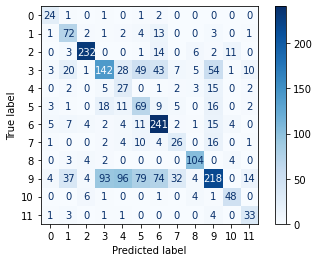


F1 scores: [0.67605634 0.58064516 0.88888889 0.45007924 0.23478261 0.38547486
 0.69054441 0.37681159 0.85245902 0.43643644 0.74418605 0.62264151]

Mean F1 : 0.578250509343895

Accuracy : 0.5651577503429356


In [ ]:
show_confusion(model, test_dataset)

In [ ]:
model.save("./model055")
!zip -r ../gdrive/MyDrive/ann_dataset/HW2/model055.zip ./model055
from google.colab import files
files.download("./")

In [ ]:
validation_dataset = test_dataset
Y_pred = model.predict(validation_dataset)
y_pred = np.argmax(Y_pred, axis=1)
y_test= np.concatenate([y for x, y in validation_dataset], axis=0)

35/35 [==============================] - 1s 24ms/step


In [ ]:
y_test

array([6, 3, 9, ..., 9, 2, 3], dtype=int32)